## Install libs

In [1]:
#import standart package
import sys
import os
import re
import pandas as pd
import numpy as np
import requests

from matplotlib import pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [2]:
#import library in order to work with vk api
!{sys.executable} -m pip install vk_api
import vk_api

In [3]:
#import library in order to work with hedden password
import getpass

In [4]:
#import library in order to work with progress bar
!{sys.executable} -m pip install tqdm
from tqdm import tqdm_notebook as tqdm

In [5]:
#import library in order to work with graph
!{sys.executable} -m pip install markov_clustering
import markov_clustering as mc

In [6]:
#import library in order to work with web-sraping
!{sys.executable} -m pip install beautifulsoup4
from bs4 import BeautifulSoup as bs 

In [7]:
#!conda install -c anaconda -y -p {sys.prefix} basemap
from mpl_toolkits.basemap import Basemap

In [8]:
print('If you want to make html version of your map, say \'yes\', else \'no\'')
IS_INSTAL = input()
#import library in order to work with web-sraping
if IS_INSTAL == 'yes':
    !{sys.executable} -m pip install folium
    import folium
else:
    print('OK, it is your choice')

If you want to make html version of your map, say 'yes', else 'no'
yes


## Connect to VK api

In [9]:
print("Please, enter your vk login:")
login = input()
password = getpass.getpass("Enter your password (hidden):")

Please, enter your vk login:
79151492105
Enter your password (hidden):········


In [10]:
def captcha_handler(captcha):
    url = captcha.get_url()
    print(url)
    webbrowser.open(url, new = 2)
    key = input("Enter captcha code: ").strip()
    return captcha.try_again(key)

In [11]:
def auth_handler():
    key = input("Enter authentication code: ")
    remember_device = False
    return key, remember_device

In [12]:
vk = vk_api.VkApi(login, password,
                  captcha_handler = captcha_handler, auth_handler=auth_handler)  

try:
    vk.auth()
except vk_api.exceptions.BadPassword:
    print("Username or password is incorrect! \nPlese enter login again:")
    login = input()
    password = getpass.getpass("Enter your password again (hidden):")
    vk = vk_api.VkApi(login, password,
                      captcha_handler = captcha_handler, auth_handler=auth_handler)
    vk.auth()
except vk_api.exceptions.AccessDenied:
    raise ValueError("No access")
except:
    raise ValueError("Something wrong! Check everything")

In [13]:
#user_id = 'nick_1963'
user_id = 'val.shishkov'
my_info = vk.method('users.get', {'user_ids': user_id, 'fields':'bdate'})

user_id = my_info[0]['id']
my_info

[{'bdate': '6.4',
  'first_name': 'Валентин',
  'id': 146770615,
  'last_name': 'Шишков'}]

## Collect friends's information

In [14]:
def make_info(info):
    nan = np.nan
    size = len(info)
    data = {
        'users_id' : list(map(lambda i: int(info[i]['id']) if 'id' in info[i] else nan, range(size))), 
        'sex_id' : list(map(lambda i: int(info[i]['sex']) if 'sex' in info[i] else nan, range(size))),
        'first_name' : list(map(lambda i: info[i]['first_name'] if 'first_name' in info[i] else nan, range(size))),
        'last_name' : list(map(lambda i: info[i]['last_name'] if 'last_name' in info[i] else nan, range(size))),
        'city_id' : list(map(lambda i: int(info[i]['city']['id']) if 'city' in info[i] and 'id' in info[i]['city'] else nan, range(size))),
        'city_name' : list(map(lambda i: info[i]['city']['title'] if 'city' in info[i] and 'title' in info[i]['city'] else nan, range(size))),
        'home_name' : list(map(lambda i: info[i]['home_town'] if 'home_town' in info[i] else nan, range(size))),
        'univer_id' : list(map(lambda i: int(info[i]['universities'][0]['id']) if 'universities' in info[i] and len(info[i]['universities'])>1 else nan, range(size))),
        'univer_name' : list(map(lambda i: info[i]['universities'][0]['name'] if 'universities' in info[i] and len(info[i]['universities'])>1 else nan, range(size))),
        'school_id' : list(map(lambda i: int(info[i]['schools'][0]['id']) if 'schools' in info[i] and len(info[i]['schools'])>1 else nan, range(size))),
        'school_name' : list(map(lambda i: info[i]['schools'][0]['name'] if 'schools' in info[i] and len(info[i]['schools'])>1 else nan, range(size))),
        'occupt_id' : list(map(lambda i: int(info[i]['occupation']['id']) if 'occupation' in info[i] and 'id' in info[i]['occupation'] else nan, range(size))),
        'occupt_name' : list(map(lambda i: info[i]['occupation']['name'] if 'occupation' in info[i] and 'name' in info[i]['occupation'] else nan, range(size))),
        'occupt_type' : list(map(lambda i: info[i]['occupation']['type'] if 'occupation' in info[i] and 'type' in info[i]['occupation'] else nan, range(size))),
        'bd_year_id' : list(map(lambda i: int(info[i]['bdate'].split(r'.')[2]) if 'bdate' in info[i] and len(info[i]['bdate'].split(r'.'))>2 else nan, range(size))),
        'bd_mont_id' : list(map(lambda i: int(info[i]['bdate'].split(r'.')[1]) if 'bdate' in info[i] else nan, range(size))),
        'bd_day_id' : list(map(lambda i: int(info[i]['bdate'].split(r'.')[0]) if 'bdate' in info[i] else nan, range(size)))
    }
    
    df_info = pd.DataFrame(data=data)
    return df_info

def make_comm(user_id, friends_list):
    
    if 'comm_{}.csv'.format(user_id) in os.listdir("info_user_id"):
        df_comm = pd.read_csv('info_user_id/comm_{}.csv'.format(user_id))
        df_comm.set_index('users_id', inplace=True)
        df_comm.columns = list(map(lambda ind: int(ind), df_comm.columns))
    else:
        df_comm = pd.DataFrame(columns=friends_list)
        df_comm['users_id'] = friends_list
        df_comm.set_index('users_id', inplace=True)
        for idx in tqdm(friends_list):
            try: 
                frx = vk.method('friends.get', {'user_id':idx})['items']
                col = np.unique(list(map(lambda fr: fr if fr in friends_list else 0, frx)))
                col = np.delete(col, 0)
                df_comm.loc[idx][col] = 1
            except:
                print('User {} was deleted'.format(idx))

        df_comm.replace(np.nan, 0, inplace=True)
        df_comm.to_csv('info_user_id/comm_{}.csv'.format(user_id))
    return df_comm

def make_city(user_id, friends_list):
    
    if 'city_{}.csv'.format(user_id) in os.listdir("info_user_id"):
        df_city = pd.read_csv('info_user_id/city_{}.csv'.format(user_id), index_col=0)
    else:
        print('You have {} friends. How many friends can I choose:'.format(len(friends_list)))
        friends_num = int(input())
        friends_list = friends_list[:friends_num]
        
        friends_friends_list = [friends_list]
        for friend in tqdm(friends_list):
            try: 
                friends_list_i = vk.method('friends.get', {'user_id': friend})['items']
                friends_friends_list.append(friends_list_i)
            except:
                print('User {} was deleted'.format(friend))
        
        friends_friends_list = np.unique(np.concatenate(friends_friends_list)).tolist()
        max_size = 999
        df_city = pd.DataFrame(columns=['city_name'])
        for friends_slice in tqdm([friends_friends_list[i*max_size : (i+1)*max_size] \
                                   for i in range(int(len(friends_friends_list)/max_size)+1)]):
            
            friends_str = str(friends_slice)[1:][:-1]
            info = vk.method('users.get', {'user_ids': friends_str,
                                            'fields': 'city'})
            nan = np.nan
            size = len(info)
            data = {
                'city_name': list(map(lambda i: info[i]['city']['title'] if 'city' in info[i] and 'title' in info[i]['city'] else nan, range(size))),
            }

            df_city_x = pd.DataFrame(data)
            df_city = pd.concat([df_city, df_city_x])
            
        df_city = df_city['city_name'].value_counts().reset_index()
        df_city.columns = ['city_name', 'count']
        df_city.to_csv('info_user_id/city_{}.csv'.format(user_id))
    return df_city

def build_friends(user_id):
    try:
        friends_list = vk.method('friends.get', {'user_id': user_id})['items']
    except:
        vk = vk_api.VkApi(login, password,
                  captcha_handler = captcha_handler, auth_handler=auth_handler)
        vk.auth()
        friends_list = vk.method('friends.get', {'user_id': user_id})['items']
    
    friends_str = str([user_id] + friends_list)[1:][:-1]
    info = vk.method('users.get', {'user_ids': friends_str,
                                   'fields': 'city, bdate, home_town, occupation, schools, sex, universities'})
    
    try:
        os.stat('info_user_id')
    except:
        os.mkdir('info_user_id')
    print('Just second, collect information of your friends')
    df_info = make_info(info)
    print('One moment, collect information of friendships')
    df_comm = make_comm(user_id, friends_list)
    print('Almost end, colletc information of friends\'s friends\'s cities')
    df_city = make_city(user_id, friends_list)
    
    return df_info, df_comm, df_city, friends_list

In [15]:
df_info, df_comm, df_city, friends_list = build_friends(user_id)

Just second, collect information of your friends
One moment, collect information of friendships
Almost end, colletc information of friends's friends's cities


In [16]:
df_city.shape

(565, 2)

In [17]:
df_info.head()

,bd_day_id,bd_mont_id,bd_year_id,city_id,city_name,first_name,home_name,last_name,occupt_id,occupt_name,occupt_type,school_id,school_name,sex_id,univer_id,univer_name,users_id
0,6.0,4.0,NaN,1.0,Москва,Валентин,Москва,Шишков,11571.0,РЭШ,university,NaN,NaN,2,11571.0,РЭШ,146770615
1,14.0,8.0,NaN,1.0,Москва,Анна,,Тюменцева,1859.0,МосГУ,university,NaN,NaN,1,1859.0,МосГУ,388733
2,23.0,6.0,NaN,1.0,Москва,Евгений,NaN,Соколов,289.0,МПГУ (бывш. МГПИ им. Ленина) (до 2015),university,NaN,NaN,2,NaN,NaN,809452
3,9.0,4.0,1992.0,1.0,Москва,Дмитрий,NaN,Сорокин,128.0,НИУ ВШЭ (ГУ-ВШЭ),university,NaN,NaN,2,NaN,NaN,1211407
4,NaN,NaN,NaN,NaN,NaN,DELETED,NaN,,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,1398749


## Make and clustering graph

In [18]:
adj_matrix = df_comm.as_matrix()
adj_matrix.shape

(302, 302)

In [19]:
#Delete removed users
ind = np.arange(adj_matrix.shape[0])[adj_matrix.sum(axis=0) < 3]
adj_matrix = np.delete(adj_matrix, ind, 0)
adj_matrix = np.delete(adj_matrix, ind, 1)
adj_matrix.shape

(251, 251)

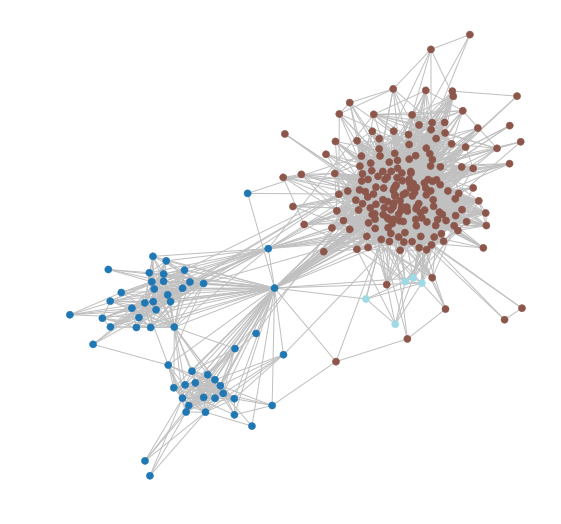

In [20]:
result = mc.run_mcl(adj_matrix)
clusters = mc.get_clusters(result)

fig = plt.figure(figsize=(9, 9))
mc.draw_graph(adj_matrix, clusters, node_size=50, with_labels=False, edge_color="silver")
fig.savefig('info_user_id/graph_{}.png'.format(user_id), dpi=300)

In [21]:
def make_hist(df_info, df_comm, clusters):
    #Make new columns
    df_info['comm_id'] = None
    for cl in range(len(clusters)):
        com_users_id = df_comm.reset_index().loc[np.array(clusters[cl])]['users_id'].as_matrix()
        df_info.set_index('users_id', inplace=True)
        df_info['comm_id'].loc[com_users_id] = cl
        df_info.reset_index(inplace=True)
    
    
    columns = ['city_id', 'occupt_id', 'school_id', 'sex_id', 'univer_id']
    f, ax = plt.subplots(len(columns), 1, figsize=(10, 4*len(columns)))
        
    for i, col in enumerate(columns):    
        ax[i].set_title(col)
        data = []
        labels = []
        for comm in df_info['comm_id'].dropna().unique():
            data.append(df_info[df_info['comm_id'] == comm][col].dropna())
            labels.append(str(comm+1) + 'st community')
        
        ax[i].hist(data, bins=30, alpha=0.8, label=labels)
        ax[i].legend()
    
    plt.show()
    

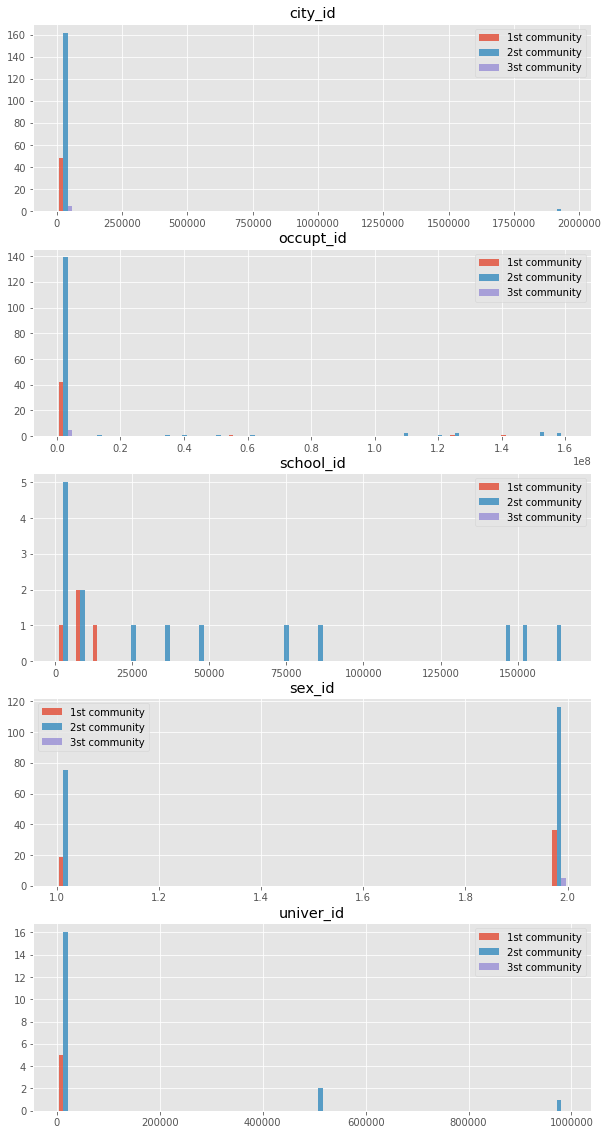

In [22]:
make_hist(df_info, df_comm, clusters)

In [23]:
def look_people():
    print('You have {} community'.format(df_info['comm_id'].dropna().unique().max() + 1))
    print('Enter a number of community')
    comm = input()
    try:
        comm = int(comm)
        if comm in df_info['comm_id'].dropna().unique():
            print('Look at most popular people in this community')
            com_users_id = df_info[df_info['comm_id'] == comm]['users_id'].as_matrix()
            df = df_comm.loc[com_users_id][com_users_id]
            adj = df.as_matrix()
            ind = adj.sum(axis=1).argsort()[-5:][::-1]
            ind = df.reset_index()['users_id'][ind].as_matrix()


            df_info.set_index('users_id', inplace=True)
            for id_i in ind:
                print('\t{} {}'.format(df_info.loc[id_i]['first_name'], df_info.loc[id_i]['last_name']))
            df_info.reset_index('users_id', inplace=True)
        else:
            print('Sorry, you have not commuity with this number')
    except:
        print('Sorry, enter a number')
    

In [24]:
look_people()

You have 3 community
Enter a number of community
0
Look at most popular people in this community
	Егор Иванов
	Даниил Евсеев
	Александр Пшеничников
	Антон Белоусов
	Таня Рафикова


In [25]:
look_people()

You have 3 community
Enter a number of community
1
Look at most popular people in this community
	Вагиз Нуруллов
	Ринат Назмеев
	Дмитрий Очков
	Павел Лебедев
	Даниил Вишнев


In [26]:
look_people()

You have 3 community
Enter a number of community
2
Look at most popular people in this community
	Дима Карпенко
	Алексей Самков
	Миша Цымбал
	Денис Старков
	Николай Ященко


## Make map of your frends

In [ ]:
def make_cord_city(df):

    df.set_index('city_name', inplace=True)
    df['lat'] = np.nan
    df['lon'] = np.nan
    for city in tqdm(df.index):
        ADD_CORD = False
        #Check Russian wikipedia
        if ADD_CORD == False:
            WIKI_URL = 'https://ru.wikipedia.org/wiki/' + str(city)
            req = requests.get(WIKI_URL)
            soup = bs(req.content, 'lxml')
            w = soup.find_all("script")[1]
            for split_text in re.split(r'[{}]', w.text):
                if 'lat' in split_text and 'lon' in split_text:
                    cord = re.split(r'[,:]', split_text)

                    try:
                        df['lat'][city] = float(cord[1])
                        df['lon'][city] = float(cord[3])
                        ADD_CORD = True
                    except:
                        None

                    
        if ADD_CORD == False:
            WIKI_URL = 'https://en.wikipedia.org/wiki/' + str(city)
            req = requests.get(WIKI_URL)
            soup = bs(req.content, 'lxml')
            w = soup.find_all("script")[1]
            for split_text in re.split(r'[{}]', w.text):
                if 'lat' in split_text and 'lon' in split_text:
                    cord = re.split(r'[,:]', split_text)
    
                    try:
                        df['lat'][city] = float(cord[1])
                        df['lon'][city] = float(cord[3])
                        ADD_CORD = True
                    except:
                        None
    
    df.reset_index(inplace=True)
    return df

In [ ]:
df_city = make_cord_city(df_city)

In [ ]:
### FROM:https://python-graph-gallery.com/315-a-world-map-of-surf-tweets/
 
my_dpi=300
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
 
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#BBD7E8', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
 
# Add a point per position
m.scatter(df_city['lon'], df_city['lat'],
          s= 2*np.sqrt(df_city['count']),
          c='r', alpha=0.4, cmap="Set1")
 
plt.text( -170, -58, 'City of friends\'s frineds of user_{}'.format(user_id),
         ha='left', va='bottom', size=5, color='#555555' )
 
# Save as png
plt.savefig('info_user_id/map_{}.png'.format(user_id), dpi = my_dpi, bbox_inches='tight')
plt.show()

### END FROM

In [ ]:
try:
    ### FROM: https://python-graph-gallery.com/313-bubble-map-with-folium/
    m = folium.Map(location=[20,0], tiles="Mapbox Bright", zoom_start=2)

    data = df_city.dropna()
    # I can add marker one by one on the map
    for i in range(0,len(data)):
        folium.Circle(
            location=[data.iloc[i]['lat'], data.iloc[i]['lon']],
            popup=data.iloc[i]['city_name'],
            radius=np.sqrt(data.iloc[i]['count'])*1000.0,
            color='crimson',
            fill=True,
            fill_color='crimson').add_to(m)

    # Save it as html
    m.save('info_user_id/map_{}.html'.format(user_id))
    print('Open the file')
    ### END FROM
except:
    None